In [14]:
import xarray as xr
from matplotlib import pyplot as plt
from xhistogram.xarray import histogram
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.crs as ccrs
import numpy as np
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import rebin_functions as rb
import budgetcalcs as bc
# from matplotlib.axes import Axes
# from cartopy.mpl.geoaxes import GeoAxes
# GeoAxes._pcolormesh_patched = Axes.pcolormesh

In [15]:
def histsum_ds(ds,bin_data,bins,dim=None,verbose=False,hist_vars=None):
    ds = ds.copy()
    vol = ds['volcello']
    if hist_vars is not None:
        ds = ds[variables]
    ds_rebinned = xr.Dataset()
    for var in ds.data_vars:
        if verbose:
            print(var)
        if ds[var].dtype == 'float32':
            nanmask = np.isnan(ds[var])
            ds_rebinned[var] = histogram(
                bin_data.where(~nanmask), bins=[bins], dim=dim, weights=(ds[var]*vol).where(~nanmask)
            )
    return ds_rebinned

In [16]:
# WRAPPING of contours fixed by masking approach outlined here: https://github.com/SciTools/cartopy/issues/1421#issue-538090364
def z_masked_overlap(axe, X, Y, Z, source_projection=None):
    """
    for data in projection axe.projection
    find and mask the overlaps (more 1/2 the axe.projection range)

    X, Y either the coordinates in axe.projection or longitudes latitudes
    Z the data
    operation one of 'pcorlor', 'pcolormesh', 'countour', 'countourf'

    if source_projection is a geodetic CRS data is in geodetic coordinates
    and should first be projected in axe.projection

    X, Y are 2D same dimension as Z for contour and contourf
    same dimension as Z or with an extra row and column for pcolor
    and pcolormesh

    return ptx, pty, Z
    """
    import numpy.ma as ma
    if not hasattr(axe, 'projection'):
        return X, Y, Z
    if not isinstance(axe.projection, ccrs.Projection):
        return X, Y, Z

    if len(X.shape) != 2 or len(Y.shape) != 2:
        return X, Y, Z

    if (source_projection is not None and
            isinstance(source_projection, ccrs.Geodetic)):
        transformed_pts = axe.projection.transform_points(
            source_projection, X, Y)
        ptx, pty = transformed_pts[..., 0], transformed_pts[..., 1]
    else:
        ptx, pty = X, Y


    with np.errstate(invalid='ignore'):
        # diagonals have one less row and one less columns
        diagonal0_lengths = np.hypot(
            ptx[1:, 1:] - ptx[:-1, :-1],
            pty[1:, 1:] - pty[:-1, :-1]
        )
        diagonal1_lengths = np.hypot(
            ptx[1:, :-1] - ptx[:-1, 1:],
            pty[1:, :-1] - pty[:-1, 1:]
        )
        to_mask = (
            (diagonal0_lengths > (
                abs(axe.projection.x_limits[1]
                    - axe.projection.x_limits[0])) / 2) |
            np.isnan(diagonal0_lengths) |
            (diagonal1_lengths > (
                abs(axe.projection.x_limits[1]
                    - axe.projection.x_limits[0])) / 2) |
            np.isnan(diagonal1_lengths)
        )

        # TODO check if we need to do something about surrounding vertices

        # add one extra colum and row for contour and contourf
        if (to_mask.shape[0] == Z.shape[0] - 1 and
                to_mask.shape[1] == Z.shape[1] - 1):
            to_mask_extended = np.zeros(Z.shape, dtype=bool)
            to_mask_extended[:-1, :-1] = to_mask
            to_mask_extended[-1, :] = to_mask_extended[-2, :]
            to_mask_extended[:, -1] = to_mask_extended[:, -2]
            to_mask = to_mask_extended
        if np.any(to_mask):

            Z_mask = getattr(Z, 'mask', None)
            to_mask = to_mask if Z_mask is None else to_mask | Z_mask

            Z = ma.masked_where(to_mask, Z)

        return ptx, pty, Z

In [17]:
path_grid = '/archive/gam/ESM4/DECK/ESM4_piControl_D/gfdl.ncrc4-intel16-prod-openmp/history/08990101.ocean_static_no_mask_table.nc'
grid = xr.open_dataset(path_grid)

In [18]:
rootdir = '/archive/oar.gfdl.cmip6/ESM4/DECK/ESM4_piControl_D/gfdl.ncrc4-intel16-prod-openmp/pp/'
name_tracer = 'ocean_cobalt_omip_tracers_month_z'
name_rates = 'ocean_cobalt_omip_rates_year_z'
name_mom6 = 'ocean_monthly_z'
time = '.0901-0905.'
# Monthly
ext = '/av/monthly_5yr/'
month = '*'
path_tracer = rootdir+name_tracer+ext+name_tracer+time+month+'.nc'
path_mom6 = rootdir+name_mom6+ext+name_mom6+time+month+'.nc'
ds_tracer = xr.open_mfdataset(path_tracer,combine='by_coords')
ds_mom6 = xr.open_mfdataset(path_mom6,combine='by_coords')
# Annual
ext = '/av/annual_5yr/'
month = 'ann'
path_rates = rootdir+name_rates+ext+name_rates+time+month+'.nc'
ds_rates = xr.open_dataset(path_rates)

/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


### Global phytoplankton and temperature contours

In [19]:
xh = ds_tracer.xh+120
phyc = (ds_tracer['phyc']*ds_tracer['volcello']).mean(dim='time').sum(dim='z_l').roll(xh=-240,roll_coords=False).assign_coords(xh=xh).load() #
temp = (ds_mom6['thetao']).sel(z_l = slice(0,50)).mean(dim=['time','z_l']).roll(xh=-240,roll_coords=False).assign_coords(xh=xh).load() # 
grid_rolled = grid.copy().roll(xh=-240,roll_coords=False).assign_coords(xh=xh) # 
grid_rolled['geolon'] = grid_rolled['geolon'].where(grid_rolled['geolon']>=-180,
                                                    grid_rolled['geolon'].where(grid_rolled['geolon']<-180)+360)

crs_plot = ccrs.Robinson(central_longitude=-160)
crs_transform = ccrs.PlateCarree()

# Transform lat and lon onro 
pos = crs_plot.transform_points(src_crs=crs_transform,
                                x=grid_rolled['geolon'].values, y=grid_rolled['geolat'].values)
X = xr.zeros_like(phyc)+pos[:,:,0]
Y = xr.zeros_like(phyc)+pos[:,:,1]

phyc = add_cyclic_point(phyc.values)
temp = add_cyclic_point(temp.values)
X = add_cyclic_point(X.values)
Y = add_cyclic_point(Y.values)

# Define manual positions of labels
contours = [0,5,10,15,20,25]
ll = -160
manual_labels = [(ll,-70),(ll,-60),(ll,-50),(ll,-40),(ll,-30),(ll,-20),
                (ll,20),(ll,30),(ll,40),(ll,50),(ll,60),(ll,70)]
posc = manual_labels.copy()
for c in range(len(posc)):
    posc[c] = crs_plot.transform_point(src_crs=crs_transform,
                                        x=manual_labels[c][0], y=manual_labels[c][1])

/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


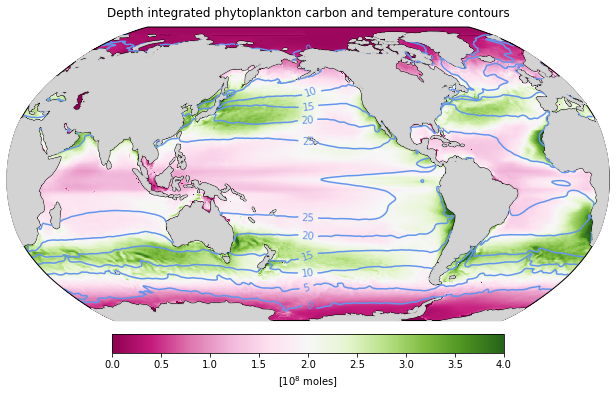

In [27]:
fig,ax = plt.subplots(figsize=(12,6),subplot_kw={'projection': crs_plot})
ax.add_feature(cfeature.LAND,facecolor='lightgray',zorder=10)
ax.coastlines(linewidth=2)
ax.set_title('Depth integrated phytoplankton carbon and temperature contours',pad=10)

# Correct issues of plotting contours from curvilinear grid
X,Y,temp = z_masked_overlap(ax, X, Y, temp, source_projection=crs_transform)

im_phyc=ax.pcolormesh(X,Y,1E-8*phyc,vmin=0,vmax=4,cmap='PiYG')
# im_phyc=ax.pcolormesh(grid_rolled['geolon'],grid_rolled['geolat'],phyc,transform=ccrs.PlateCarree())
im_temp=ax.contour(X,Y,temp,contours,colors='cornflowerblue',linestyle=':')
# im_temp=ax.contour(grid_rolled['geolon'],grid_rolled['geolat'],temp,transform=crs_transform)
ax.clabel(im_temp, inline=True, fontsize=10, manual = posc, fmt='%1.0f')

cbar = plt.colorbar(im_phyc,ax=ax,fraction=0.06,pad=0.04,orientation='horizontal')
cbar.set_label('[$10^8$ moles]')

fig.savefig('figures/osm_map.png',transparent=True,orientation='landscape',dpi=600)

### Phytoplankton, primary production, respiration as a function of temperature

In [29]:
# Calculate bgc variables as a function of temperature
bins_theta = np.arange(-2,32,1)
variables = ['phyc']
ds_tracer_rebinned = histsum_ds(ds_tracer,ds_mom6['thetao'],bins=bins_theta,dim=['xh','yh','z_l'],verbose=True,hist_vars=variables)
ds_tracer_rebinned.load()
variables = ['pp','remoc']
ds_rates_rebinned = histsum_ds(ds_rates,ds_mom6['thetao'].mean('time'),bins=bins_theta,verbose=True,hist_vars=variables)
ds_rates_rebinned.load()

phyc
pp
remoc


/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.Dataset>
Dimensions:     (thetao_bin: 33)
Coordinates:
  * thetao_bin  (thetao_bin) float64 -1.5 -0.5 0.5 1.5 ... 27.5 28.5 29.5 30.5
Data variables:
    pp          (thetao_bin) float64 1.75e+06 1.983e+06 ... 1.591e+06 2.672e+04
    remoc       (thetao_bin) float64 1.789e+06 1.999e+06 ... 1.432e+06 2.814e+04

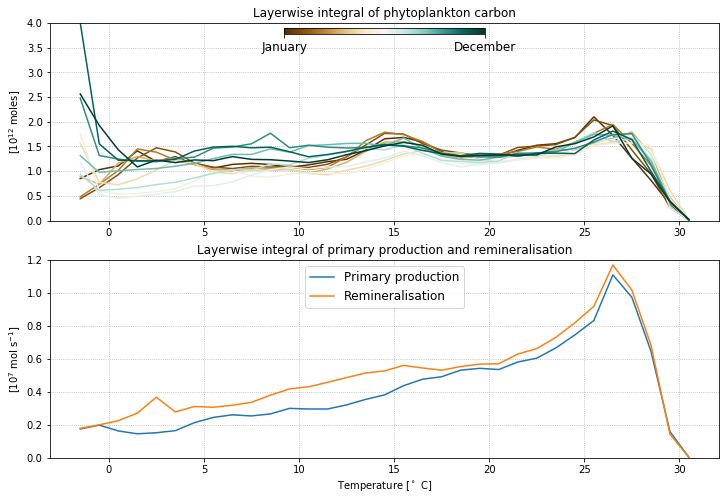

In [30]:
start = 0
stop = 1
N = 12
colors = [ cm.BrBG(x) for x in np.linspace(start, stop, N) ]

fig, (ax0,ax1) = plt.subplots(figsize = (12,8),nrows=2,gridspec_kw={'height_ratios': [1, 1]})
for t in range(12):
    ax0.plot(ds_tracer_rebinned['thetao_bin'],1E-12*ds_tracer_rebinned['phyc'].isel(time=t),color=colors[t])

ax0.set_title('Layerwise integral of phytoplankton carbon')
ax0.set_ylabel('[$10^{12}$ moles]')
ax0.set_ylim([0,4])
ax0.grid(linestyle=':')

cbaxes = inset_axes(ax0, width="30%", height="3%", loc='upper center')
# fig.add_axes([0.4, 0.8, 0.2, 0.01]) 
# plt.colorbar(cax=cbaxes, ticks=[0.,1], orientation='horizontal')
sm = plt.cm.ScalarMappable(cmap=cm.BrBG, norm=plt.Normalize(vmin=0, vmax=1))
cbar = plt.colorbar(sm,cax=cbaxes,ticks=[0,1],orientation='horizontal')
cbar.ax.set_xticklabels(['January','December'],fontsize=12)

ax1.set_title('Layerwise integral of primary production and remineralisation')
ax1.plot(ds_rates_rebinned['thetao_bin'],1E-7*ds_rates_rebinned['pp'],label='Primary production')
ax1.plot(ds_rates_rebinned['thetao_bin'],1E-7*ds_rates_rebinned['remoc'],label='Remineralisation')
ax1.grid(linestyle=':')
ax1.set_ylabel('[$10^{7}$ mol s$^{-1}$]')
ax1.set_ylim([0,1.2])
ax1.set_xlabel('Temperature [$^\circ$ C]')
ax1.legend(fontsize=12,loc='upper center')

fig.savefig('figures/osm_bgc-on-temp.png',transparent=True,orientation='landscape',dpi=600)

### Closed budget in temperature space

In [31]:
rootdir = '/archive/gam/ESM4/DECK/ESM4_piControl_D/gfdl.ncrc4-intel16-prod-openmp/'
runname = '6'
filename = '08990101.ocean_month.nc'
ds_budgets = xr.open_dataset(rootdir+runname+'/history/'+filename)
filename_grid = '08990101.ocean_static_no_mask_table.nc'
grid = xr.open_dataset(rootdir+runname+'/history/'+filename_grid)
# Name of vertical coordinate
vertc = 'zl'

o2_terms = ['o2h_tendency','o2_advection_xy','o2h_tendency_vert_remap','o2_dfxy_cont_tendency','o2_vdiffuse_impl','jo2']
o2_tend = o2_terms[0]
# Correct MOM6 tendencies to account for mass in cell
# i.e. convert from [mol kg^-1 m s^-1] to [mol m^-2 s^-1]
rho0=1035.0
for term in o2_terms[:-1]:
    ds_budgets[term] *= rho0
    
# Calculate residual error
# OXYGEN
tendsum,error = bc.calc_budget(ds_budgets,o2_terms[1:],o2_terms[0],plot=False)
ds_budgets['o2_vdiffuse_impl']=error

/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


In [32]:
prof = rb.total_rebin_layerintegral(ds_budgets[o2_terms],
                                    bin_data = ds_budgets['temp'],
                                    bins=bins_theta,
                                    dim = ['xh','yh','zl'],
                                    area = grid.areacello,
                                    block_size=None,
                                    verbose=True)

o2h_tendency
o2_advection_xy
o2h_tendency_vert_remap
o2_dfxy_cont_tendency
o2_vdiffuse_impl
jo2


In [33]:
signs = [-1,1,1]
prof['o2h_material_derivative'] = signs[0]*prof['o2h_tendency']+signs[1]*prof['o2_advection_xy']+signs[2]*prof['o2h_tendency_vert_remap']

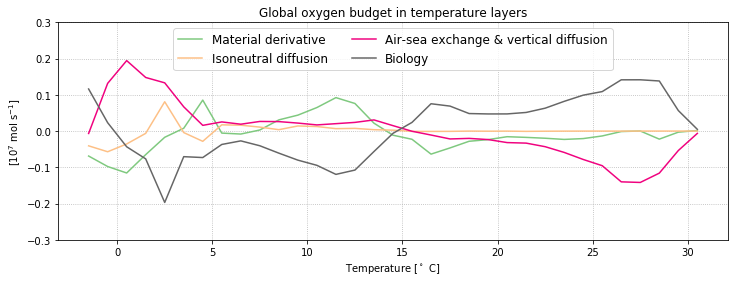

In [34]:
start = 0
stop = 1
N = 4
colors = [ cm.Accent(x) for x in np.linspace(start, stop, N) ]

terms = ['o2h_material_derivative','o2_dfxy_cont_tendency','o2_vdiffuse_impl','jo2']
useful_terms = ['Material derivative','Isoneutral diffusion','Air-sea exchange & vertical diffusion','Biology']

fig,ax0 = plt.subplots(figsize=(12,4))
count=0
for term in terms:
    ax0.plot(prof['temp_bin'],1E-7*prof[term].mean('time'),color=colors[count],label=useful_terms[count])
    count += 1

ax0.set_ylim([-0.3,0.3])
ax0.set_xlabel('Temperature [$^\circ$ C]')
ax0.set_ylabel('[10$^7$ mol s$^{-1}$]')
ax0.set_title('Global oxygen budget in temperature layers')
ax0.grid(linestyle=':')
ax0.legend(loc='upper center',fontsize=12,ncol=2) #bbox_to_anchor=(0.5, -0.2)

fig.savefig('figures/osm_o2budget-on-temp.png',transparent=True,orientation='landscape',dpi=600)